### Thinking1
在CTR点击率预估中，使用GBDT+LR的原理是什么？

答：（1）利用GBDT对特征进行转换，增加特征维度：取训练集中的部分样本通过GBDT串行地训练出多棵树，记训练完成后所有叶子节点的个数为k，对于训练集中其余的样本利用训练好的GBDT进行预测，将其所属的叶子节点位置处记为1，非所属的叶子节点处记为0，拼接每棵树所得的向量后，将最终得到k维的向量作为特征向量；  
&emsp;&emsp;（2）利用LR对完成特征转换的这部分训练集进行训练。

### Thinking2
Wide & Deep的模型结构是怎样的，为什么能通过具备记忆和泛化能力（memorization and generalization）

答：Wide&Deep的Wide部分是由线性回归模型构成，其中如需考虑特征组合则需要人为构造，Deep部分则由DNN模型构成，在训练过程中同时考虑Wide模型和Deep模型以及加权和来优化所有参数。Wide&Deep的模型结构结合了线性模型的记忆能力，即直接利用历史数据学习特征或物品的共现性，以及DNN模型的泛化能力，即通过特征相关性的传递，发掘那些历史数据中没有出现过的特征组合，使模型具有推理能力。

### Thinking3
在CTR预估中，使用FM与DNN结合的方式，有哪些结合的方式，代表模型有哪些？

答：（1）并行结构，FM和DNN分开计算：DeepFM；  
&emsp;&emsp;（2）串行结构，将FM的结果作为DNN输入：NFM。

### Thinking4
GBDT和随机森林都是基于树的算法，它们有什么区别？

答：（1）在选择样本时：GBDT每次训练的样本是固定的，而随机森林每次训练的样本是从总训练样本中随机有放回抽样得到的；  
&emsp;&emsp;（2）在生成树时：GBDT每次在上一颗树预测结果残差减小的方向上生成下一棵树，每棵树都对全部特征进行考量，树与树之间并非独立，串行生成，而随机森林每棵树都是随机选取部分特征，树与树之间相互独立，并行生成的；  
&emsp;&emsp;（3）在预测时：GBDT是将预测样本在每颗树上所属叶子节点的值相加得到最终结果，随机森林是对所有树预测结果进行投票得到最终结果。

### Thinking5
item流行度在推荐系统中有怎样的应用

答：（1）解决冷启动问题：根据流行度找到系统中的热门商品，对新用户进行推荐；  
&emsp;&emsp;（2）在个性化推荐时可以将流行度作为惩罚，因为太热门商品可能会烂俗，缺乏个性化，或者在如婚恋网站等一些情形下不适合使用热门推荐。

### Action1
使用Wide&Deep模型对movielens进行评分预测

In [2]:
import pandas as pd

# 载入数据
data = pd.read_csv('ratings.csv')

# 数据探索
data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
from sklearn.preprocessing import LabelEncoder
sparse_features = ['userId', 'movieId', 'timestamp']
target = ['rating']
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])
    
data.head()

,userId,movieId,rating,timestamp
0,0,1,3.5,340880
1,0,28,3.5,340785
2,0,31,3.5,340801
3,0,46,3.5,340790
4,0,49,3.5,340774


In [4]:
from deepctr.feature_column import SparseFeat, get_feature_names
fixlen_feature_columns = [SparseFeat(feature, data[feature].nunique(), embedding_dim=8) for feature in sparse_features]
fixlen_feature_columns[0]

SparseFeat(name='userId', vocabulary_size=7120, embedding_dim=8, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001B609525CD0>, embedding_name='userId', group_name='default_group', trainable=True)

In [5]:
# 指定LR和DNN训练所使用的特征列，并获取列名
DNN_columns = fixlen_feature_columns
LR_columns = fixlen_feature_columns
feature_names = get_feature_names(DNN_columns + LR_columns)
feature_names

['userId', 'movieId', 'timestamp']

In [6]:
from sklearn.model_selection import train_test_split
from deepctr.models import WDL

# 切分数据集
train, test = train_test_split(data, test_size=0.2)
train_input = {name: train[name].values for name in feature_names}
test_input = {name: test[name].values for name in feature_names}

# 使用WDL进行训练
model = WDL(LR_columns, DNN_columns, task='regression')
model.compile('adam', 'mse', metrics=['mse'])
history = model.fit(train_input, train[target].values, batch_size=256, epochs=5, verbose=1, validation_split=0.2, )
pred = model.predict(test_input, batch_size=256)

Epoch 1/5


C:\Users\80566\Coding\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


2622/2622 [==============================] - 156s 60ms/step - loss: 0.9398 - mse: 0.9300 - val_loss: 0.7536 - val_mse: 0.7340
Epoch 2/5
2622/2622 [==============================] - 158s 60ms/step - loss: 0.3888 - mse: 0.3591 - val_loss: 0.8028 - val_mse: 0.7603
Epoch 3/5
2622/2622 [==============================] - 153s 58ms/step - loss: 0.4616 - mse: 0.4104 - val_loss: 0.8298 - val_mse: 0.7690
Epoch 4/5
2622/2622 [==============================] - 157s 60ms/step - loss: 0.3502 - mse: 0.2893 - val_loss: 0.8436 - val_mse: 0.7810
Epoch 5/5
2622/2622 [==============================] - 156s 59ms/step - loss: 0.2789 - mse: 0.2196 - val_loss: 0.8446 - val_mse: 0.7861


In [8]:
from sklearn.metrics import mean_squared_error
mse = round(mean_squared_error(test[target].values, pred), 4)
rmse = mse**0.5
print('test RMSE:', rmse)

test RMSE: 0.8880878334939625


#### 试用GBDT+LR

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
# 载入数据
data = pd.read_csv('ratings.csv')

# 生成样本集，并切分
features = ['userId', 'movieId', 'timestamp']
target = ['rating']
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_tree, X_lr, y_tree, y_lr = train_test_split(X_train, y_train, test_size=0.5)

In [30]:
# GBDT进行特征转换
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder

grd = GradientBoostingRegressor(n_estimators=10, learning_rate=1.0, max_depth=2, min_samples_split=2, loss='ls')
grd.fit(X_tree, y_tree)

C:\Users\80566\Coding\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=10)

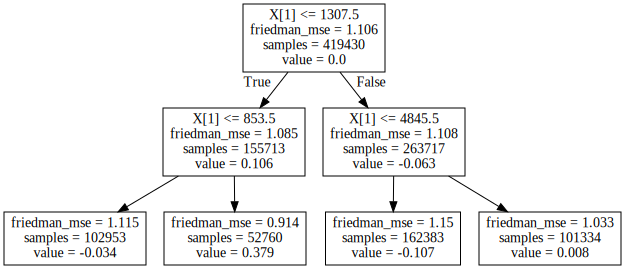

In [32]:
from sklearn import tree
import graphviz 
graph = []
for i in grd.estimators_:
    clf = i[0]
    dot_data = tree.export_graphviz(clf, out_file=None) 
    graph.append(graphviz.Source(dot_data))
graph[0]

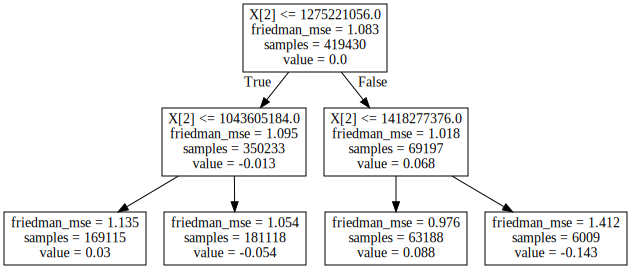

In [33]:
graph[1]

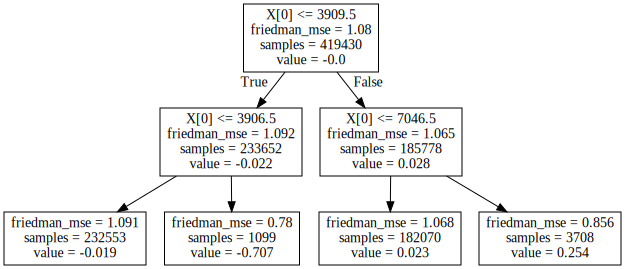

In [35]:
graph[2]

In [44]:
grd.apply(X_tree)

array([[6., 5., 5., ..., 6., 6., 6.],
       [5., 3., 5., ..., 6., 6., 2.],
       [6., 3., 2., ..., 6., 6., 6.],
       ...,
       [6., 3., 2., ..., 6., 5., 6.],
       [2., 2., 5., ..., 6., 6., 2.],
       [6., 5., 2., ..., 6., 2., 6.]])